In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 84
#novel number
t = "Frankenstein"
#novel name
s = 1
#how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,HTML version by Al Haines.
1,"Frankenstein, or the Modern Prometheus by ..."
2,"I arrived here yesterday, and my first task is..."
3,"I am already far north of London, and as I wal..."
4,Do you understand this feeling?


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,HTML version by Al Haines.,"[4, 7, 2, 2, 6]",21
1,"Frankenstein, or the Modern Prometheus by ...","[12, 2, 3, 6, 10, 2, 4, 14, 6, 7, 6, 1, 2, 11,...",234
2,"I arrived here yesterday, and my first task is...","[1, 7, 4, 9, 3, 2, 5, 4, 2, 2, 6, 2, 4, 6, 2, ...",118
3,"I am already far north of London, and as I wal...","[1, 2, 7, 3, 5, 2, 6, 3, 2, 1, 4, 2, 3, 7, 2, ...",141
4,Do you understand this feeling?,"[2, 3, 10, 4, 7]",26


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,HTML version by Al Haines.,"[4, 7, 2, 2, 6]",21,"[0, 2, 1, 1, 1]"
1,"Frankenstein, or the Modern Prometheus by ...","[12, 2, 3, 6, 10, 2, 4, 14, 6, 7, 6, 1, 2, 11,...",234,"[3, 1, 1, 2, 3, 1, 2, 4, 2, 2, 2, 0, 0, 3, 1, ..."
2,"I arrived here yesterday, and my first task is...","[1, 7, 4, 9, 3, 2, 5, 4, 2, 2, 6, 2, 4, 6, 2, ...",118,"[1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, ..."
3,"I am already far north of London, and as I wal...","[1, 2, 7, 3, 5, 2, 6, 3, 2, 1, 4, 2, 3, 7, 2, ...",141,"[1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Do you understand this feeling?,"[2, 3, 10, 4, 7]",26,"[1, 1, 3, 1, 2]"


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [18]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [19]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [20]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [21]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [22]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [23]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [24]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,HTML version by Al Haines.,"[4, 7, 2, 2, 6]",21,[0 2 1 1 1],5,0.000000
1,"Frankenstein, or the Modern Prometheus by ...","[12, 2, 3, 6, 10, 2, 4, 14, 6, 7, 6, 1, 2, 11,...",234,[3 1 1 2 3 1 2 4 2 2 2 0 0 3 1 0 0 1 0 2 2 1 1...,72,-0.266667
2,"I arrived here yesterday, and my first task is...","[1, 7, 4, 9, 3, 2, 5, 4, 2, 2, 6, 2, 4, 6, 2, ...",118,[1 2 1 3 1 1 1 1 1 1 2 1 2 2 1 1 2 1 4 3 1 1 2...,42,0.275000
3,"I am already far north of London, and as I wal...","[1, 2, 7, 3, 5, 2, 6, 3, 2, 1, 4, 2, 3, 7, 2, ...",141,[1 1 4 1 1 1 2 1 1 1 1 1 1 1 1 3 1 1 1 1 2 1 1...,44,-0.250000
4,Do you understand this feeling?,"[2, 3, 10, 4, 7]",26,[1 1 3 1 2],8,0.000000


Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,HTML version by Al Haines.,21,5,0.000000
1,"Frankenstein, or the Modern Prometheus by ...",234,72,-0.266667
2,"I arrived here yesterday, and my first task is...",118,42,0.275000
3,"I am already far north of London, and as I wal...",141,44,-0.250000
4,Do you understand this feeling?,26,8,0.000000


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster['cluster'] = km.labels_

In [32]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,90.411028,29.308271,-0.006918
1,297.525424,98.372881,0.157269
2,162.387097,53.532258,0.385306
3,221.536364,72.127273,-0.056611
4,20.787879,6.705234,-0.000353
5,59.479167,19.458333,-0.884675
6,49.660131,16.392157,0.455254
7,123.736196,40.582822,-0.004029
8,452.222222,146.777778,0.204420


In [33]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [35]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

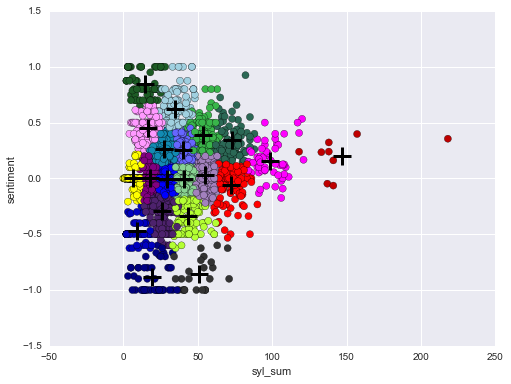

In [36]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [37]:
df_cluster_3 = df_cluster

In [38]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,HTML version by Al Haines.,21,5,0.000000,4
1,"Frankenstein, or the Modern Prometheus by ...",234,72,-0.266667,3
2,"I arrived here yesterday, and my first task is...",118,42,0.275000,16
3,"I am already far north of London, and as I wal...",141,44,-0.250000,9
4,Do you understand this feeling?,26,8,0.000000,4


In [39]:
X = df_cluster_3.drop(0, axis=1)

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

In [41]:
df_cluster_3['cluster'] = km.labels_

In [42]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,90.411028,29.308271,-0.006918
1,297.525424,98.372881,0.157269
2,162.387097,53.532258,0.385306
3,221.536364,72.127273,-0.056611
4,20.787879,6.705234,-0.000353
5,59.479167,19.458333,-0.884675
6,49.660131,16.392157,0.455254
7,123.736196,40.582822,-0.004029
8,452.222222,146.777778,0.204420


Create 3 Clusters with no syl_sum

In [43]:
df_cluster_no_syl = df_cluster

In [44]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [45]:
X = df_cluster_no_syl.drop(0, axis=1)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [48]:
df_cluster_no_syl['cluster'] = km.labels_

In [49]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,52.380153,-0.096289
1,136.988981,0.055233
2,126.183516,0.312724


Create 5 Clusters

In [50]:
df_cluster_5 = df_cluster

In [51]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,HTML version by Al Haines.,21,5,0.000000,4
1,"Frankenstein, or the Modern Prometheus by ...",234,72,-0.266667,3
2,"I arrived here yesterday, and my first task is...",118,42,0.275000,16
3,"I am already far north of London, and as I wal...",141,44,-0.250000,9
4,Do you understand this feeling?,26,8,0.000000,4


In [52]:
X = df_cluster_5.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_5['cluster'] = km.labels_

In [56]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,111.581535,36.476019,0.026910
1,125.050980,40.717647,0.277707
2,41.596973,13.531693,0.101100
3,241.017544,78.887719,0.153739
4,84.904891,27.804348,-0.453747


Find ideal amount of clusters for novel

In [ ]:
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

In [ ]:
k_range = range(2,150)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

In [ ]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

Find Sentiment Pattern - need to work on this code to make it more universal.

20 pieces

In [57]:
df_novel['total_char'].sum()

332626

In [58]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [59]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [60]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:152]
df_novel['total_char'][152:305]
df_novel['total_char'][305:458]
df_novel['total_char'][458:586]
df_novel['total_char'][586:751]
df_novel['total_char'][751:942]
df_novel['total_char'][942:1144]
df_novel['total_char'][1144:1310]
df_novel['total_char'][1310:1495]
df_novel['total_char'][1495:1639]
df_novel['total_char'][1639:1785]
df_novel['total_char'][1785:1975]
df_novel['total_char'][1975:2146]
df_novel['total_char'][2146:2298]
df_novel['total_char'][2298:2453]
df_novel['total_char'][2453:2614]
df_novel['total_char'][2614:2772]
df_novel['total_char'][2772:2927]
df_novel['total_char'][2927:3089]
df_novel['total_char'][3089:3300]


In [61]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
152
0.12878491702
152
305
0.0922261303511
305
458
0.108637636873
458
586
0.135539378157
586
751
0.0762461410643
751
942
0.0445236992865
942
1144
0.0425930927571
1144
1310
0.055215004206
1310
1495
0.0365388749139
1495
1639
0.167114911516
1639
1785
0.0773028351025
1785
1975
0.0563706377687
1975
2146
0.01710930314
2146
2298
0.0819920658654
2298
2453
0.0321433799176
2453
2614
0.0384140891315
2614
2772
0.0631635667469
2772
2927
0.0722814688299
2927
3089
0.0506959308695
3089
3300
0.0192189284517


In [62]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.12878492  0.09222613  0.10863764  0.13553938  0.07624614  0.0445237
  0.04259309  0.055215    0.03653887  0.16711491  0.07730284  0.05637064
  0.0171093   0.08199207  0.03214338  0.03841409  0.06316357  0.07228147
  0.05069593  0.01921893]


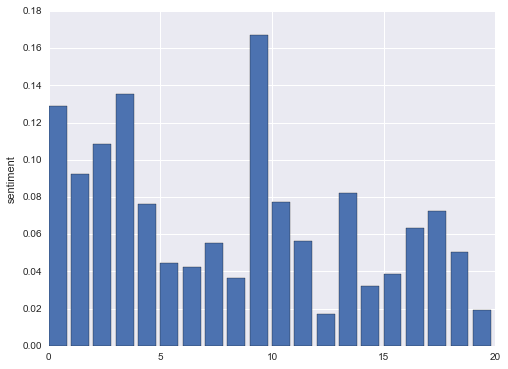

In [63]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern

In [67]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
3304,The light of that conflagration will fade away...,"[3, 5, 2, 4, 13, 4, 4, 4, 2, 5, 4, 2, 5, 4, 3,...",77,"[1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, ...",25,0.40
3305,"My spirit will sleep in peace, or if it thinks...","[2, 6, 4, 5, 2, 5, 2, 2, 2, 6, 2, 4, 3, 6, 5, 4]",60,"[1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1]",20,-0.25
3306,"Farewell.""",[8],8,[3],3,0.00
3307,He sprang from the cabin window as he said thi...,"[2, 6, 4, 3, 5, 6, 2, 2, 4, 4, 4, 3, 3, 4, 5, ...",76,"[1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...",24,0.00
3308,He was soon borne away by the waves and lost i...,"[2, 3, 4, 5, 4, 2, 3, 5, 3, 4, 2, 8, 3, 8]",56,"[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2]",17,0.00


In [68]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -200
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [69]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:1061]
df_novel['total_char'][1061:2199]
df_novel['total_char'][2199:3301]


KeyboardInterrupt: 

In [70]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
1061
0.0920433593857
1061
2199
0.0585270505547
2199
3301
0.0499786831528


In [71]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.09204336  0.05852705  0.04997868]


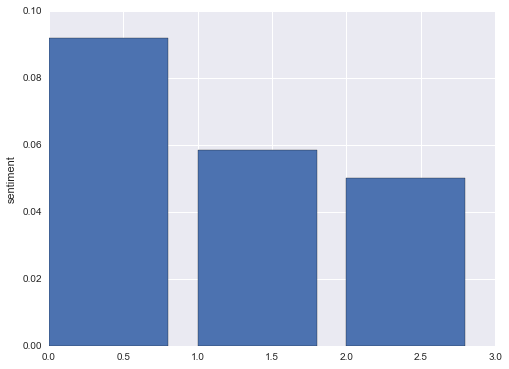

In [72]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers